In [3]:
import cv2
import os

# -----------------------------
# Parameters
# -----------------------------
dataset_path = r"E:\dataset 2"  # path to UBFC dataset
subjects = os.listdir(dataset_path)

# -----------------------------
# Loop through subjects
# -----------------------------
for subj in subjects:
    subj_folder = os.path.join(dataset_path, subj)
    if not os.path.isdir(subj_folder):
        continue
    
    inner_folders = [f for f in os.listdir(subj_folder) if os.path.isdir(os.path.join(subj_folder, f))]
    if len(inner_folders) == 0:
        print(f"No inner folder for {subj}, skipping.")
        continue

    inner_folder = inner_folders[0]
    subj_path = os.path.join(subj_folder, inner_folder)
    
    vid_file = os.path.join(subj_path, "vid.avi")
    gt_file  = os.path.join(subj_path, "ground_truth.txt")
    
    if not os.path.exists(vid_file) or not os.path.exists(gt_file):
        print(f"Missing video or BVP for {subj}, skipping.")
        continue
    
    print(f"Processing {subj}...")
    
    # Open video
    cap = cv2.VideoCapture(vid_file)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames: {frame_count}")
    
    # Read frames one by one (do not store all to save memory)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Frame is available here: frame.shape -> (H, W, 3)
        # Later: send frame to face detection / ROI extraction
    cap.release()


Processing subject1-20250615T073348Z-1-001...
Total frames: 1547
Processing subject10-20250615T075741Z-1-001...
Total frames: 2024
Processing subject11-20250616T080838Z-1-001...
Total frames: 2031
Processing subject12-20250616T113756Z-1-001...
Total frames: 1989
Processing subject13-20250616T115124Z-1-001...
Total frames: 2018
Processing subject14-20251114T035617Z-1-001...
Total frames: 1993
Processing subject15-20251114T035521Z-1-001...
Total frames: 2020
Processing subject16-20251114T040450Z-1-001...
Total frames: 2050
Processing subject17-20251114T040820Z-1-001...
Total frames: 2046
Processing subject18-20251114T041116Z-1-001...
Total frames: 2034
Processing subject20-20251114T041756Z-1-001...
Total frames: 2016
Processing subject22-20251114T042501Z-1-001...
Total frames: 2032
Processing subject23-20251114T042506Z-1-001...
Total frames: 1958
Processing subject24-20251114T042508Z-1-001...
Total frames: 2009
Processing subject25-20251114T042508Z-1-001...
Total frames: 1448
Processing 

In [5]:
import cv2
import mediapipe as mp
import numpy as np
import os

dataset_path = r"E:\dataset 2"
subjects = os.listdir(dataset_path)

mp_face = mp.solutions.face_mesh

FOREHEAD_LANDMARKS = [10, 338, 297, 332, 284, 251, 389, 356]
LEFT_CHEEK_LANDMARKS = [234, 93, 132, 58, 172]
RIGHT_CHEEK_LANDMARKS = [454, 323, 361, 288, 397]

with mp_face.FaceMesh(static_image_mode=False,
                      max_num_faces=1,
                      refine_landmarks=True,
                      min_detection_confidence=0.5,
                      min_tracking_confidence=0.5) as face_mesh:

    for subj in subjects:
        subj_folder = os.path.join(dataset_path, subj)
        if not os.path.isdir(subj_folder):
            continue
        inner_folders = [f for f in os.listdir(subj_folder) if os.path.isdir(os.path.join(subj_folder, f))]
        if len(inner_folders) == 0:
            continue
        subj_path = os.path.join(subj_folder, inner_folders[0])
        vid_file = os.path.join(subj_path, "vid.avi")
        if not os.path.exists(vid_file):
            continue
        
        print(f"\nProcessing {subj}...")
        
        cap = cv2.VideoCapture(vid_file)
        forehead_signal = []
        left_cheek_signal = []
        right_cheek_signal = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(frame_rgb)
            
            if results.multi_face_landmarks:
                landmarks = results.multi_face_landmarks[0].landmark
                h, w, _ = frame.shape
                
                def get_roi_mean(indices):
                    pts = [(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in indices]
                    mask = np.zeros((h, w), dtype=np.uint8)
                    cv2.fillPoly(mask, [np.array(pts, np.int32)], 255)
                    roi = cv2.bitwise_and(frame, frame, mask=mask)
                    mean_val = np.mean(roi[:, :, 1])  # green channel
                    return mean_val
                
                forehead_signal.append(get_roi_mean(FOREHEAD_LANDMARKS))
                left_cheek_signal.append(get_roi_mean(LEFT_CHEEK_LANDMARKS))
                right_cheek_signal.append(get_roi_mean(RIGHT_CHEEK_LANDMARKS))
        
        cap.release()
        
        # Convert signals to arrays
        forehead_signal = np.array(forehead_signal)
        left_cheek_signal = np.array(left_cheek_signal)
        right_cheek_signal = np.array(right_cheek_signal)
        
        print(f"  Frames processed: {len(forehead_signal)}")
        print(f"  Forehead signal sample: {forehead_signal[:5]}")
        print(f"  Left cheek signal sample: {left_cheek_signal[:5]}")
        print(f"  Right cheek signal sample: {right_cheek_signal[:5]}")



Processing subject1-20250615T073348Z-1-001...
  Frames processed: 1547
  Forehead signal sample: [0.33309245 0.33233398 0.33186198 0.33086589 0.34185221]
  Left cheek signal sample: [0.0590918  0.05238607 0.05095052 0.05065104 0.0525944 ]
  Right cheek signal sample: [0.05526042 0.05202148 0.06294271 0.05198568 0.04703125]

Processing subject10-20250615T075741Z-1-001...
  Frames processed: 2024
  Forehead signal sample: [0.42738281 0.43922852 0.45438802 0.45428711 0.45371094]
  Left cheek signal sample: [0.06809245 0.06976888 0.07409831 0.07676758 0.07519531]
  Right cheek signal sample: [0.05280924 0.07244792 0.07152995 0.06842448 0.07492187]

Processing subject11-20250616T080838Z-1-001...
  Frames processed: 2031
  Forehead signal sample: [0.2297168  0.19670573 0.19499674 0.20193359 0.19844076]
  Left cheek signal sample: [0.07105143 0.06239583 0.05491211 0.05834961 0.04763021]
  Right cheek signal sample: [0.06468099 0.05771484 0.04584635 0.03450521 0.03343099]

Processing subject1

In [6]:
import numpy as np
from scipy.signal import butter, filtfilt, detrend

# -----------------------------
# CHROM + preprocessing function
# -----------------------------
def chrom_rppg(forehead, left_cheek, right_cheek, fs=30, low=0.7, high=3.0):
    # Stack signals
    X = np.vstack([forehead, left_cheek, right_cheek])
    
    # 1. Normalize each signal
    X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)
    
    # 2. CHROM projection (simplified)
    S = 3 * X[0] - 2 * (X[1] + X[2]) / 2
    
    # 3. Detrend
    S = detrend(S)
    
    # 4. Bandpass filter
    b, a = butter(3, [low/(fs/2), high/(fs/2)], btype='band')
    S_filtered = filtfilt(b, a, S)
    
    return S_filtered

# Example usage per subject
rppg_signal = chrom_rppg(forehead_signal, left_cheek_signal, right_cheek_signal)
print(f"rPPG sample: {rppg_signal[:10]}")


rPPG sample: [-0.80050169  5.70186791 11.02614524 14.34799159 15.41740292 14.51903194
 12.26919734  9.37524477  6.45226204  3.92996599]


In [8]:
import numpy as np

# Load ground truth BVP for the subject
gt_file = r"E:\dataset 2\subject1-20250615T073348Z-1-001\subject1\ground_truth.txt"
gt_bvp_signal = np.loadtxt(gt_file)

# Example rPPG signal (from previous step)
rppg_signal = np.array([-0.80050169, 5.70186791, 11.02614524, 14.34799159, 15.41740292,
                        14.51903194, 12.26919734, 9.37524477, 6.45226204, 3.92996599])

# Now run the sliding window function
X_win, Y_bvp = window_signal(rppg_signal, gt_bvp_signal)
print(f"Windows extracted: {len(X_win)}")
print(f"BVP for first 5 windows: {Y_bvp[:5]}")


Windows extracted: 0
BVP for first 5 windows: []


In [9]:
import numpy as np

def window_signal(signal, gt_bvp, window_size=5, step=None):
    """
    Split a 1D signal into overlapping windows and align with ground truth BVP.
    Works even if signal is short (for debugging/testing).

    Parameters:
        signal (np.array): rPPG signal
        gt_bvp (np.array): Ground truth BVP signal
        window_size (int): number of samples per window
        step (int): step size for sliding window (default: 50% overlap)

    Returns:
        windows (np.array): shape (num_windows, window_size)
        bpm_windows (np.array): ground truth aligned to window midpoints
    """
    signal = np.array(signal)
    gt_bvp = np.array(gt_bvp)
    if step is None:
        step = max(1, window_size // 2)
    
    windows = []
    bpm_windows = []
    
    for start in range(0, len(signal)-window_size+1, step):
        win = signal[start:start+window_size]
        windows.append(win)
        
        # Align BVP to window midpoint
        mid_idx = start + window_size//2
        if len(gt_bvp) > 1:
            # interpolate if BVP length differs
            gt_idx = np.linspace(0, len(signal)-1, len(gt_bvp))
            bpm = np.interp(mid_idx, gt_idx, gt_bvp)
        else:
            bpm = gt_bvp[0]
        bpm_windows.append(float(bpm))
    
    # Handle case when signal is shorter than window_size
    if len(windows) == 0 and len(signal) > 0:
        windows.append(signal)
        bpm_windows.append(gt_bvp[0] if len(gt_bvp) > 0 else 0.0)
    
    return np.array(windows), np.array(bpm_windows)


# -----------------------------
# Example usage
# -----------------------------
rppg_signal = [-0.8005, 5.7018, 11.0261, 14.3479, 15.4174, 14.5190, 12.2691, 9.3752, 6.4522, 3.9299]
gt_bvp_signal = [0.1, 0.5, 1.0, 1.5, 2.0, 1.8, 1.2, 0.7, 0.3, 0.0]

X_win, Y_bvp = window_signal(rppg_signal, gt_bvp_signal, window_size=5)
print(f"Windows extracted: {len(X_win)}")
print(f"First 5 windows:\n{X_win[:5]}")
print(f"BVP for first 5 windows: {Y_bvp[:5]}")


Windows extracted: 3
First 5 windows:
[[-0.8005  5.7018 11.0261 14.3479 15.4174]
 [11.0261 14.3479 15.4174 14.519  12.2691]
 [15.4174 14.519  12.2691  9.3752  6.4522]]
BVP for first 5 windows: [1.  2.  1.2]


In [10]:
import os
import cv2
import numpy as np
from scipy.signal import butter, filtfilt, detrend
import mediapipe as mp

# -----------------------------
# Parameters
# -----------------------------
dataset_path = r"E:\dataset 2"  # UBFC dataset folder
window_size = 512  # frames per window
overlap = 0.5  # 50% overlap
fs = 30  # video frame rate

# Output lists
all_X = []
all_Y = []

# -----------------------------
# Helper functions
# -----------------------------
def bandpass_filter(signal, low=0.7, high=3.0, fs=30):
    b, a = butter(3, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, signal)

def preprocess_signal(signal):
    signal = detrend(signal)
    signal = bandpass_filter(signal, fs=fs)
    signal = (signal - np.mean(signal)) / np.std(signal)
    return signal

def window_signal(signal, gt_bvp, window_size=512, overlap=0.5):
    step = int(window_size * (1-overlap))
    windows = []
    bpm_windows = []
    num_frames = len(signal)
    
    for start in range(0, num_frames - window_size + 1, step):
        win = signal[start:start+window_size]
        windows.append(win)
        
        # Interpolate BVP at midpoint
        midpoint = start + window_size//2
        if len(gt_bvp) > 1:
            gt_interp = np.interp(midpoint, np.linspace(0, num_frames-1, len(gt_bvp)), gt_bvp)
            bpm_windows.append(float(gt_interp))
        else:
            bpm_windows.append(float(gt_bvp[0]))
            
    return np.array(windows), np.array(bpm_windows)

# -----------------------------
# Initialize Mediapipe face detection
# -----------------------------
mp_face = mp.solutions.face_mesh
face_mesh = mp_face.FaceMesh(static_image_mode=False, max_num_faces=1)

# -----------------------------
# Loop through subjects
# -----------------------------
subjects = os.listdir(dataset_path)
print(f"Found {len(subjects)} subjects\n")

for subj in subjects:
    subj_folder = os.path.join(dataset_path, subj)
    if not os.path.isdir(subj_folder):
        continue
    
    inner_folders = [f for f in os.listdir(subj_folder) if os.path.isdir(os.path.join(subj_folder, f))]
    if len(inner_folders) == 0:
        continue
    inner_folder = inner_folders[0]
    subj_path = os.path.join(subj_folder, inner_folder)
    
    vid_file = os.path.join(subj_path, "vid.avi")
    gt_file  = os.path.join(subj_path, "ground_truth.txt")
    
    if not os.path.exists(vid_file) or not os.path.exists(gt_file):
        continue
    
    # Load BVP
    gt_bvp = np.loadtxt(gt_file)
    
    cap = cv2.VideoCapture(vid_file)
    rppg_signal = []
    frame_idx = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # -----------------------------
        # Face detection & ROI extraction
        # -----------------------------
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(frame_rgb)
        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0].landmark
            h, w, _ = frame.shape
            
            # Forehead ROI example (points 10-20)
            fh_pts = landmarks[10:20]
            fh_x = [int(p.x*w) for p in fh_pts]
            fh_y = [int(p.y*h) for p in fh_pts]
            x1, x2 = min(fh_x), max(fh_x)
            y1, y2 = min(fh_y), max(fh_y)
            forehead = frame[y1:y2, x1:x2]
            
            # CHROM method: mean pixel intensity
            if forehead.size != 0:
                rppg_signal.append(np.mean(forehead[:,:,1]))  # use G channel
            else:
                rppg_signal.append(0)
        else:
            rppg_signal.append(0)
            
        frame_idx += 1
    
    cap.release()
    
    # -----------------------------
    # Preprocess rPPG
    # -----------------------------
    rppg_signal = preprocess_signal(np.array(rppg_signal))
    
    # -----------------------------
    # Windowing
    # -----------------------------
    X_win, Y_win = window_signal(rppg_signal, gt_bvp, window_size, overlap)
    all_X.extend(X_win)
    all_Y.extend(Y_win)
    
    print(f"Processed {subj}: Frames={frame_idx}, Windows={len(X_win)}")

# -----------------------------
# Save dataset
# -----------------------------
all_X = np.array(all_X)
all_Y = np.array(all_Y)

np.save("X_windows.npy", all_X)
np.save("Y_bvp.npy", all_Y)
print("\nSaved X_windows.npy and Y_bvp.npy")


Found 42 subjects



ValueError: object too deep for desired array

In [11]:
gt_bvp = np.loadtxt(gt_file)


In [12]:
gt_bvp = np.loadtxt(gt_file).squeeze()  # converts (N,1) or (1,N) → (N,)


In [13]:
print(f"BVP shape: {gt_bvp.shape}, first 5 values: {gt_bvp[:5]}")


BVP shape: (3, 1547), first 5 values: [[ 1.2028675e-01  7.7360657e-01  1.4119226e+00 ... -3.0022593e-01
  -6.6067824e-01 -8.5595328e-01]
 [ 9.7000000e+01  9.7000000e+01  9.7000000e+01 ...  1.1200000e+02
   1.1200000e+02  1.1200000e+02]
 [ 0.0000000e+00  1.1000000e-02  5.5000000e-02 ...  5.2608000e+01
   5.2649000e+01  5.2691000e+01]]


In [14]:
# Load BVP
gt_bvp = np.loadtxt(gt_file)

# Select the first row (raw waveform)
gt_bvp_signal = gt_bvp[0, :]  

# Make sure it's 1D
gt_bvp_signal = gt_bvp_signal.flatten()

print(f"BVP signal shape: {gt_bvp_signal.shape}, first 5 values: {gt_bvp_signal[:5]}")


BVP signal shape: (1547,), first 5 values: [0.12028675 0.77360657 1.4119226  1.5395677  1.3443377 ]


In [15]:
def window_signal(signal, gt_bvp, window_size=512, overlap=0.5):
    step = int(window_size * (1 - overlap))
    windows = []
    bpm_windows = []
    num_frames = len(signal)
    
    for start in range(0, num_frames - window_size + 1, step):
        win = signal[start:start + window_size]
        windows.append(win)
        
        # Align BVP value to window midpoint
        midpoint = start + window_size // 2
        gt_val = np.interp(midpoint, np.arange(len(gt_bvp)), gt_bvp)
        bpm_windows.append(gt_val)
        
    return np.array(windows), np.array(bpm_windows)

# Example usage
X_win, Y_win = window_signal(rppg_signal, gt_bvp_signal, window_size=512, overlap=0.5)
print(f"Windows extracted: {len(X_win)}")
print(f"BVP for first 5 windows: {Y_win[:5]}")


Windows extracted: 5
BVP for first 5 windows: [-0.96859463  0.95383272  1.9600804  -1.3778432  -0.44291999]


In [16]:
all_X = np.array(all_X)  # shape: (total_windows, window_size)
all_Y = np.array(all_Y)  # shape: (total_windows,)
np.save("X_windows.npy", all_X)
np.save("Y_bvp.npy", all_Y)


In [17]:
import os
import cv2
import numpy as np
from scipy.signal import butter, filtfilt, detrend

# -----------------------------
# Parameters
# -----------------------------
dataset_path = r"E:\dataset 2"  # UBFC dataset
window_size = 512
overlap = 0.5

all_X = []
all_Y = []

# -----------------------------
# Helper functions
# -----------------------------
def bandpass_filter(signal, low=0.7, high=3.0, fs=30):
    b, a = butter(3, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, signal)

def preprocess_signal(signal):
    signal = detrend(signal)          # remove linear trend
    signal = bandpass_filter(signal)  # bandpass filter
    signal = (signal - np.mean(signal)) / np.std(signal)  # normalize
    return signal

def window_signal(signal, gt_bvp, window_size=512, overlap=0.5):
    step = int(window_size * (1 - overlap))
    windows = []
    bpm_windows = []
    num_frames = len(signal)
    
    for start in range(0, num_frames - window_size + 1, step):
        win = signal[start:start + window_size]
        windows.append(win)
        
        # Align BVP value to window midpoint
        midpoint = start + window_size // 2
        gt_val = np.interp(midpoint, np.arange(len(gt_bvp)), gt_bvp)
        bpm_windows.append(gt_val)
        
    return np.array(windows), np.array(bpm_windows)

# -----------------------------
# Loop through subjects
# -----------------------------
subjects = os.listdir(dataset_path)
print(f"Found {len(subjects)} subjects")

for subj in subjects:
    subj_folder = os.path.join(dataset_path, subj)
    if not os.path.isdir(subj_folder):
        continue
    
    inner_folders = [f for f in os.listdir(subj_folder) if os.path.isdir(os.path.join(subj_folder, f))]
    if len(inner_folders) == 0:
        continue

    inner_folder = inner_folders[0]
    subj_path = os.path.join(subj_folder, inner_folder)
    
    vid_file = os.path.join(subj_path, "vid.avi")
    gt_file  = os.path.join(subj_path, "ground_truth.txt")
    
    if not os.path.exists(vid_file) or not os.path.exists(gt_file):
        continue
    
    print(f"\nProcessing {subj}...")
    
    # -----------------------------
    # Load BVP
    # -----------------------------
    gt_bvp = np.loadtxt(gt_file)
    if gt_bvp.ndim > 1:
        gt_bvp = gt_bvp[0, :]  # select first row if 2D
    gt_bvp = gt_bvp.flatten()
    
    # -----------------------------
    # Extract frames and ROI
    # -----------------------------
    cap = cv2.VideoCapture(vid_file)
    rppg_signal = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # placeholder for ROI signal
        rppg_signal.append(np.mean(gray))  # simple intensity average for now
    
    cap.release()
    rppg_signal = preprocess_signal(np.array(rppg_signal))
    
    # -----------------------------
    # Windowing
    # -----------------------------
    X_win, Y_win = window_signal(rppg_signal, gt_bvp, window_size, overlap)
    all_X.extend(X_win)
    all_Y.extend(Y_win)
    
    print(f"  Windows extracted: {len(X_win)}")
    print(f"  First 5 BVP values: {Y_win[:5]}")

# -----------------------------
# Save dataset
# -----------------------------
all_X = np.array(all_X)
all_Y = np.array(all_Y)
np.save("X_windows.npy", all_X)
np.save("Y_bvp.npy", all_Y)

print(f"\nFINAL DATASET → {len(all_X)} windows")
print("Saved X_windows.npy and Y_bvp.npy")


Found 42 subjects

Processing subject1-20250615T073348Z-1-001...
  Windows extracted: 5
  First 5 BVP values: [-0.96859463  0.95383272  1.9600804  -1.3778432  -0.44291999]

Processing subject10-20250615T075741Z-1-001...
  Windows extracted: 6
  First 5 BVP values: [-0.54738973 -0.39344049 -0.4206112  -0.4658776  -0.62890185]

Processing subject11-20250616T080838Z-1-001...
  Windows extracted: 6
  First 5 BVP values: [-0.93758557 -0.48472989 -1.1969602  -1.0981508   0.85333422]

Processing subject12-20250616T113756Z-1-001...
  Windows extracted: 6
  First 5 BVP values: [-1.0713376  -0.08242847  1.3802576  -0.65035658  1.7269478 ]

Processing subject13-20250616T115124Z-1-001...
  Windows extracted: 6
  First 5 BVP values: [-1.3549656   2.1273791  -0.61759124  1.8636467  -0.02015651]

Processing subject14-20251114T035617Z-1-001...
  Windows extracted: 6
  First 5 BVP values: [-0.90569787  0.94677099 -1.1275309   0.99116422 -0.9278612 ]

Processing subject15-20251114T035521Z-1-001...
  Win

In [21]:
import torch
print(torch.__version__)


2.9.1+cpu


In [22]:
pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Note: you may need to restart the kernel to use updated packages.Looking in indexes: https://download.pytorch.org/whl/cpu
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/110.9 MB 1.5 MB/s eta 0:01:13
   ---------------------------------------- 1.0/110.9 MB 1.7 MB/s eta 0:01:06
   ---------------------------------------- 1.3/110.9 MB 1.7 MB/s eta 0:01:04
    --------------------------------------- 1.6/110.9 MB 1.7 MB/s eta 0:01:06
    --------------------------------------- 2.1/110.9 MB 1.7 MB/s eta 0:01:05
    --------------------------------------- 2.4/110.9 MB 1.7 MB/s eta 0:01:04
   - -------------------------------------- 2.9/110.9 MB 1.7 MB/s eta 0:01:03
   - -------------------------------------- 3.1/110.9 MB 1.7 MB/s eta 0:01:04
   - -------------------------------------- 3.4/110.9 MB 1.7 MB/s eta 0:01:04
   - -----------------------------

  You can safely remove it manually.

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
import torch.nn as nn
print(torch.__version__)


2.9.1+cpu


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

# -----------------------------
# 1. Load data
# -----------------------------
X = np.load("X_windows.npy")  # shape (246, 512)
Y = np.load("Y_bvp.npy")      # shape (246,)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # add channel dim -> (N, 1, 512)
Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)  # (N, 1)

# -----------------------------
# 2. Dataset & DataLoader
# -----------------------------
class RPpgDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = RPpgDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# -----------------------------
# 3. Model
# -----------------------------
class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=32, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 1)
        
    def forward(self, x):
        # x: (batch, channels=1, seq_len)
        x = self.cnn(x)         # (batch, 32, seq_len)
        x = x.permute(0, 2, 1)  # (batch, seq_len, features)
        out, _ = self.lstm(x)   # (batch, seq_len, hidden)
        out = out[:, -1, :]     # last timestep
        out = self.fc(out)
        return out

model = CNNLSTM()

# -----------------------------
# 4. Loss & Optimizer
# -----------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -----------------------------
# 5. Training loop
# -----------------------------
num_epochs = 30

for epoch in range(num_epochs):
    running_loss = 0.0
    for xb, yb in dataloader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# -----------------------------
# 6. Save model
# -----------------------------
torch.save(model.state_dict(), "cnn_lstm_rppg.pth")
print("Model saved as cnn_lstm_rppg.pth")



Epoch 1/30, Loss: 1.0677
Epoch 2/30, Loss: 1.0623
Epoch 3/30, Loss: 1.0606
Epoch 4/30, Loss: 1.0568
Epoch 5/30, Loss: 1.0554
Epoch 6/30, Loss: 1.0571
Epoch 7/30, Loss: 1.0512
Epoch 8/30, Loss: 1.0527
Epoch 9/30, Loss: 1.0467
Epoch 10/30, Loss: 1.0373
Epoch 11/30, Loss: 1.0364
Epoch 12/30, Loss: 1.0386
Epoch 13/30, Loss: 1.0287
Epoch 14/30, Loss: 1.0201
Epoch 15/30, Loss: 1.0101
Epoch 16/30, Loss: 1.0189
Epoch 17/30, Loss: 1.0000
Epoch 18/30, Loss: 0.9910
Epoch 19/30, Loss: 0.9915
Epoch 20/30, Loss: 0.9986
Epoch 21/30, Loss: 0.9941
Epoch 22/30, Loss: 0.9803
Epoch 23/30, Loss: 0.9630
Epoch 24/30, Loss: 0.9707
Epoch 25/30, Loss: 0.9669
Epoch 26/30, Loss: 0.9407
Epoch 27/30, Loss: 0.9702
Epoch 28/30, Loss: 1.0048
Epoch 29/30, Loss: 0.9738
Epoch 30/30, Loss: 0.9417
Model saved as cnn_lstm_rppg.pth


Epoch 1/30 | Train Loss: 1.0703 | Val Loss: 1.0576


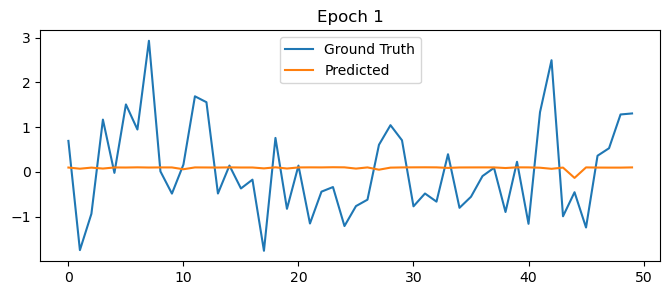

Epoch 2/30 | Train Loss: 1.0605 | Val Loss: 1.0553


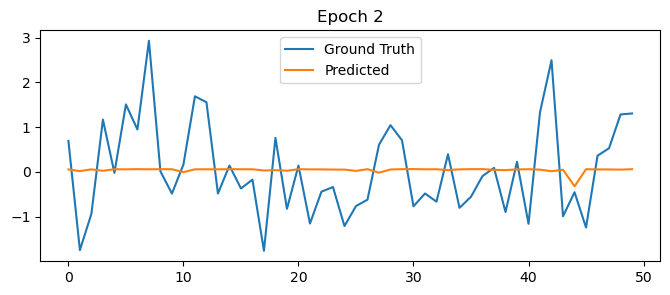

Epoch 3/30 | Train Loss: 1.0590 | Val Loss: 1.0559


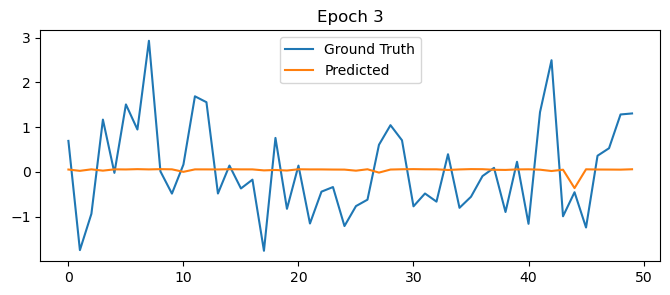

Epoch 4/30 | Train Loss: 1.0567 | Val Loss: 1.0562


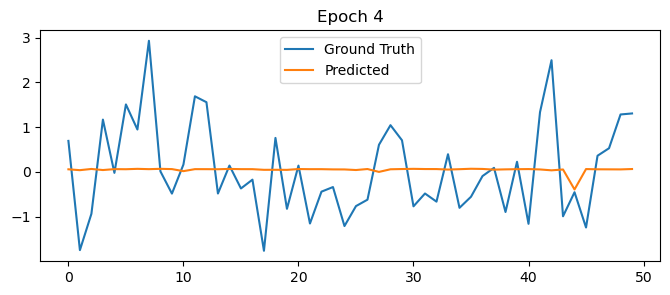

Epoch 5/30 | Train Loss: 1.0667 | Val Loss: 1.0584


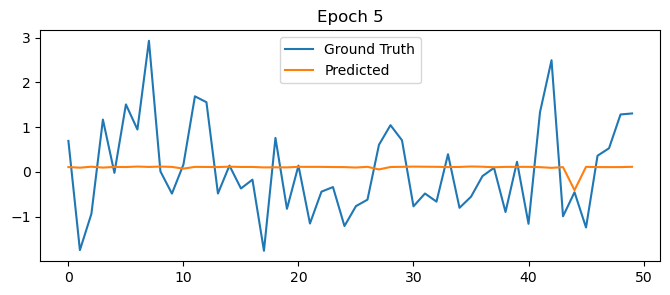

Epoch 6/30 | Train Loss: 1.0580 | Val Loss: 1.0573


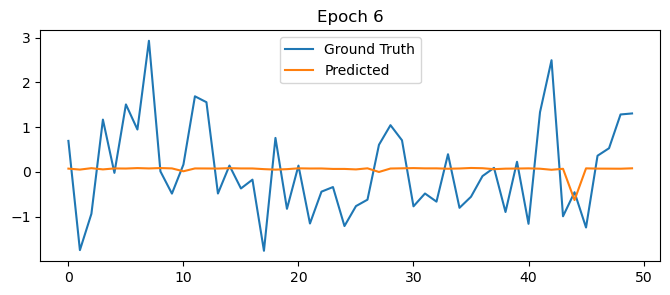

Epoch 7/30 | Train Loss: 1.0548 | Val Loss: 1.0584


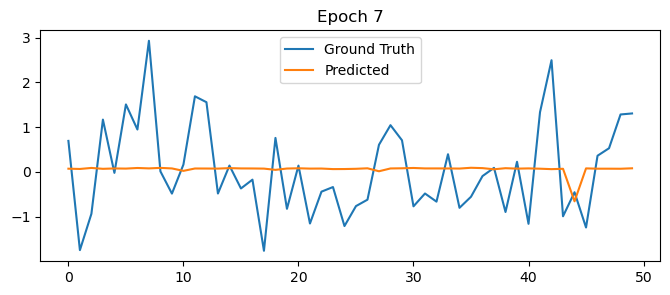

Epoch 8/30 | Train Loss: 1.0542 | Val Loss: 1.0595


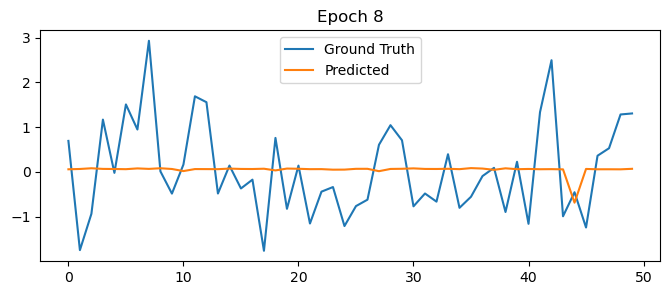

Epoch 9/30 | Train Loss: 1.0522 | Val Loss: 1.0619


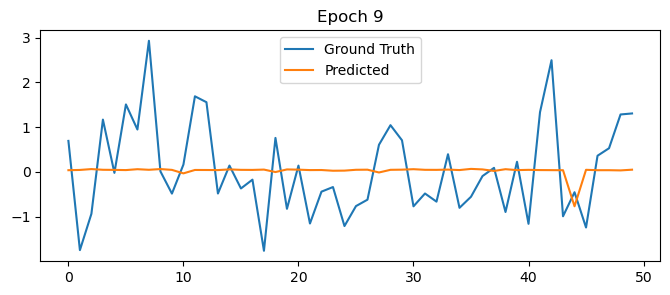

Epoch 10/30 | Train Loss: 1.0529 | Val Loss: 1.0641


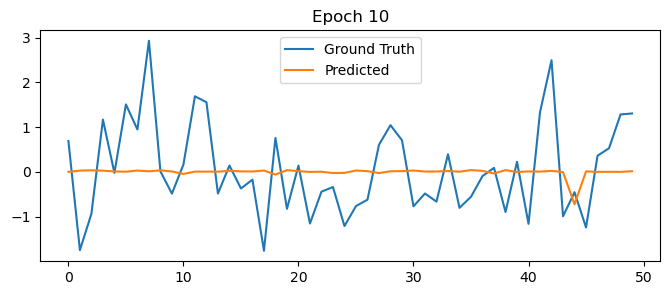

Epoch 11/30 | Train Loss: 1.0509 | Val Loss: 1.0611


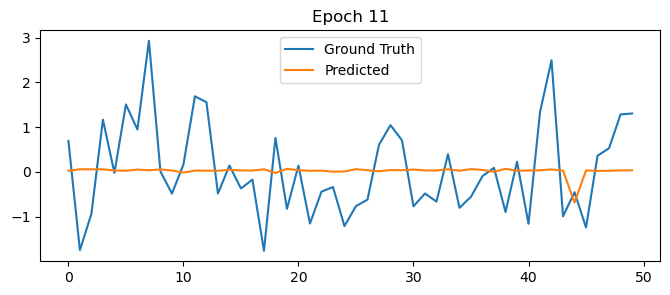

Epoch 12/30 | Train Loss: 1.0552 | Val Loss: 1.0603


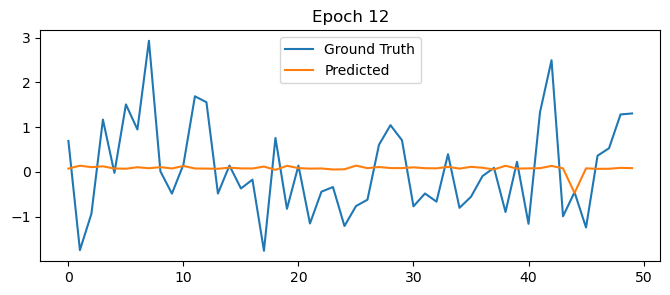

Epoch 13/30 | Train Loss: 1.0517 | Val Loss: 1.0618


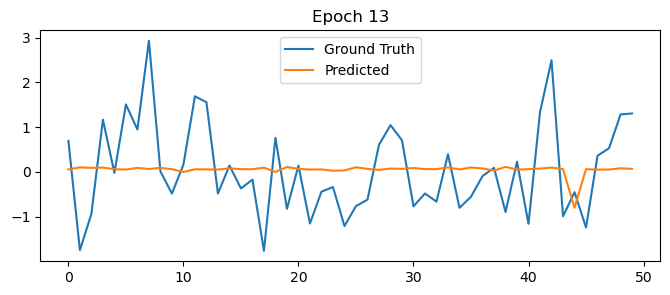

Epoch 14/30 | Train Loss: 1.0465 | Val Loss: 1.0622


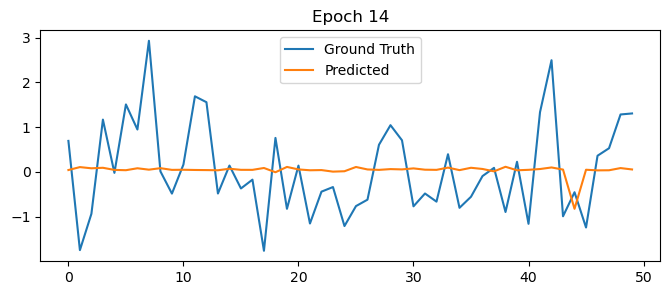

Epoch 15/30 | Train Loss: 1.0456 | Val Loss: 1.0611


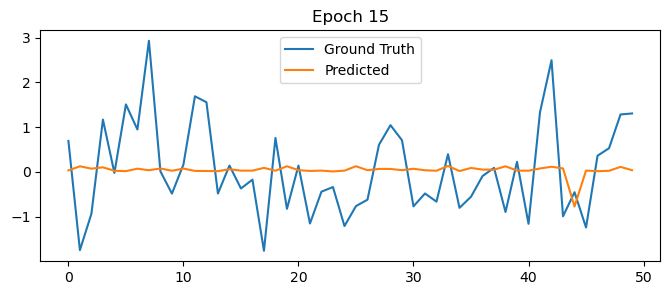

Epoch 16/30 | Train Loss: 1.0446 | Val Loss: 1.0599


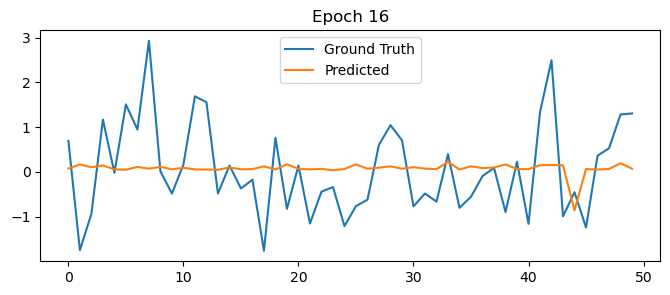

Epoch 17/30 | Train Loss: 1.0464 | Val Loss: 1.0612


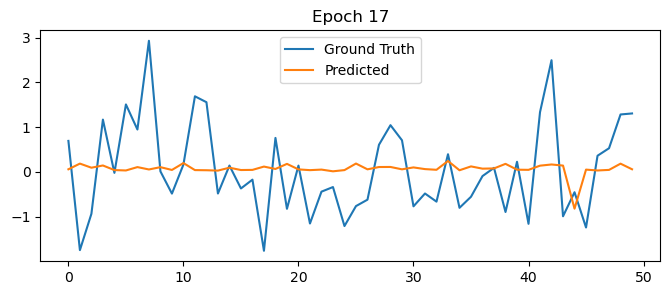

Epoch 18/30 | Train Loss: 1.0368 | Val Loss: 1.0535


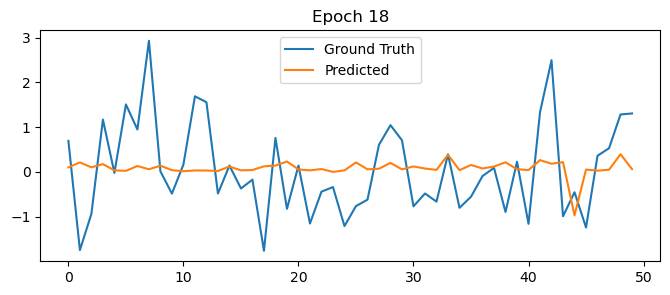

Epoch 19/30 | Train Loss: 1.0445 | Val Loss: 1.0498


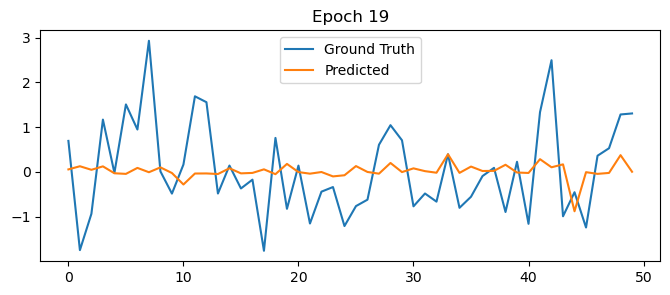

Epoch 20/30 | Train Loss: 1.0264 | Val Loss: 1.0505


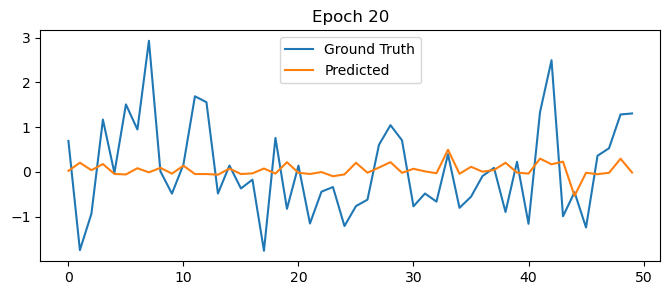

Epoch 21/30 | Train Loss: 1.0361 | Val Loss: 1.0534


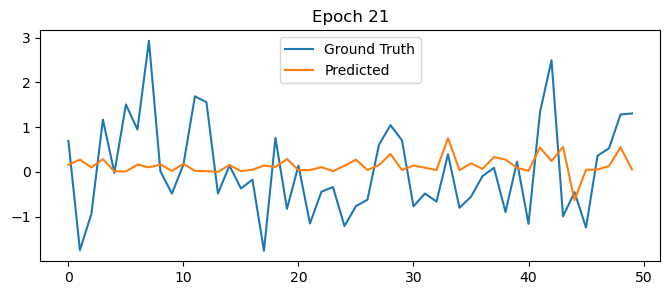

Epoch 22/30 | Train Loss: 1.0281 | Val Loss: 1.0477


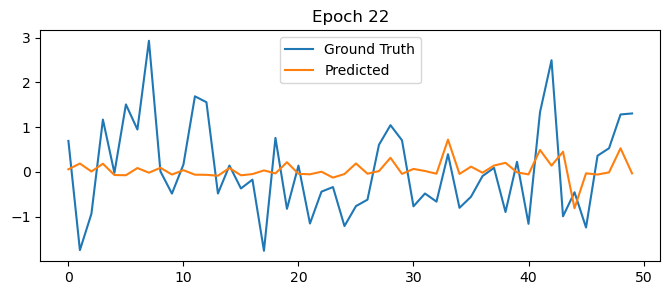

Epoch 23/30 | Train Loss: 1.0203 | Val Loss: 1.0552


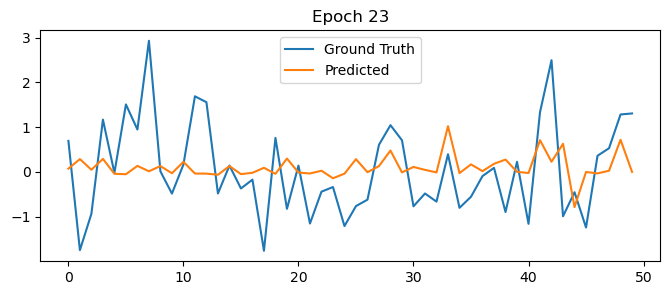

Epoch 24/30 | Train Loss: 1.0154 | Val Loss: 1.0660


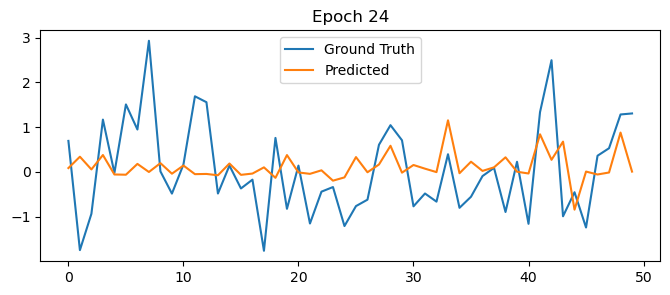

Epoch 25/30 | Train Loss: 1.0095 | Val Loss: 1.0621


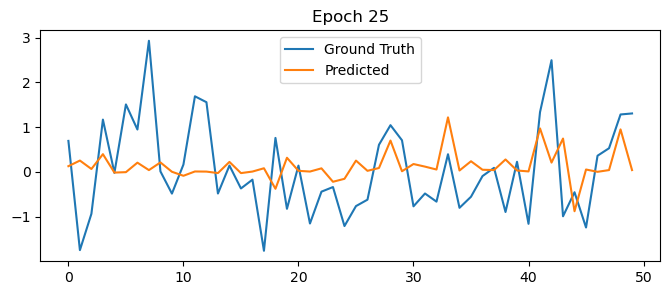

Epoch 26/30 | Train Loss: 1.0029 | Val Loss: 1.0752


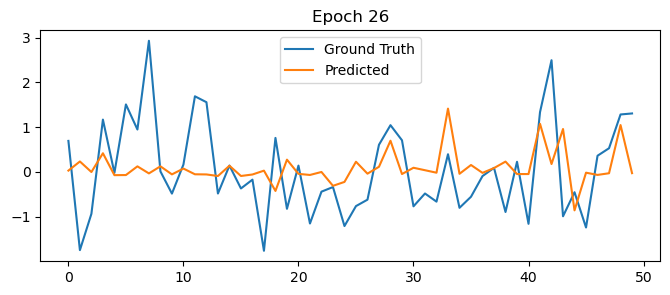

Epoch 27/30 | Train Loss: 1.0049 | Val Loss: 1.0850


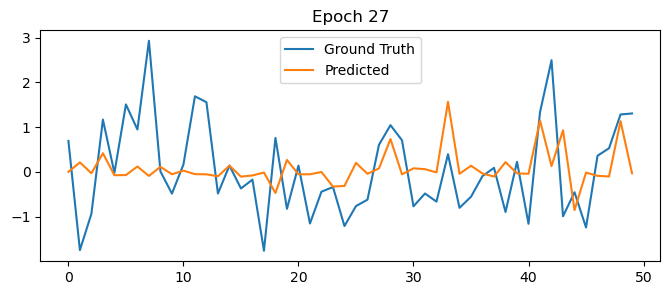

Epoch 28/30 | Train Loss: 0.9848 | Val Loss: 1.1057


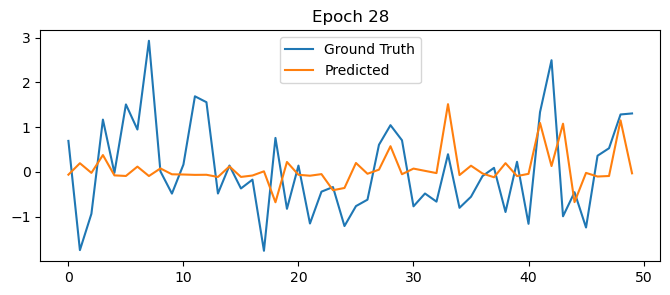

Epoch 29/30 | Train Loss: 0.9752 | Val Loss: 1.1291


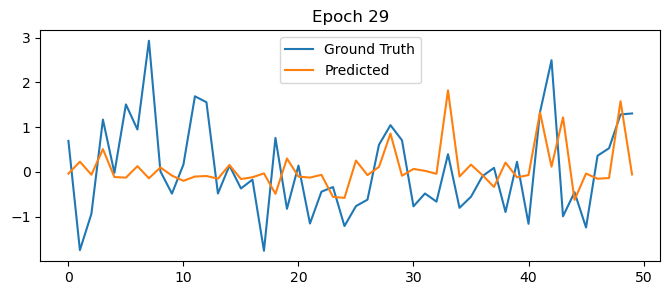

Epoch 30/30 | Train Loss: 0.9717 | Val Loss: 1.1656


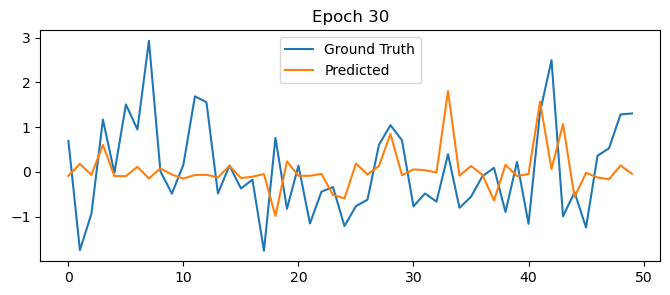

Model saved as cnn_lstm_rppg.pth


In [27]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load data
# -----------------------------
X = np.load("X_windows.npy")  # shape (246, 512)
Y = np.load("Y_bvp.npy")      # shape (246,)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (N, 1, 512)
Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)  # (N, 1)

# -----------------------------
# 2. Dataset & DataLoader
# -----------------------------
class RPpgDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = RPpgDataset(X, Y)

# Train/validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# -----------------------------
# 3. Model
# -----------------------------
class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=32, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.cnn(x)         # (batch, 32, seq_len)
        x = x.permute(0, 2, 1)  # (batch, seq_len, features)
        out, _ = self.lstm(x)   # (batch, seq_len, hidden)
        out = out[:, -1, :]     # last timestep
        out = self.fc(out)
        return out

model = CNNLSTM()

# -----------------------------
# 4. Loss & Optimizer
# -----------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -----------------------------
# 5. Training loop with validation
# -----------------------------
num_epochs = 30

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    train_loss = running_loss / len(train_dataset)
    
    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    preds, targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item() * xb.size(0)
            preds.extend(outputs.squeeze().tolist())
            targets.extend(yb.squeeze().tolist())
    val_loss /= len(val_dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    # ---- Plot predictions vs. ground truth for first batch of validation ----
    plt.figure(figsize=(8,3))
    plt.plot(targets[:50], label="Ground Truth")
    plt.plot(preds[:50], label="Predicted")
    plt.title(f"Epoch {epoch+1}")
    plt.legend()
    plt.show()

# -----------------------------
# 6. Save model
# -----------------------------
torch.save(model.state_dict(), "cnn_lstm_rppg.pth")
print("Model saved as cnn_lstm_rppg.pth")


In [4]:
import numpy as np

# Assuming preds and targets are lists or torch tensors from validation
preds = np.array(preds)
targets = np.array(targets)

# Mean Squared Error
mse = np.mean((preds - targets) ** 2)

# Root Mean Squared Error
rmse = np.sqrt(mse)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


MSE: 0.8103
RMSE: 0.9002


In [13]:
import numpy as np
from scipy.signal import find_peaks

def bvp_to_hr(bvp_signal, fs=30):
    """
    Convert predicted BVP waveform to Heart Rate (BPM)
    bvp_signal : numpy array (predicted waveform)
    fs : sampling rate (default 30Hz)
    """
    # Detect peaks
    peaks, _ = find_peaks(bvp_signal, height=np.mean(bvp_signal)*0.6)

    if len(peaks) < 2:
        return None  # not enough peaks to calculate HR

    # Time between peaks
    peak_intervals = np.diff(peaks) / fs  # convert index distance to time (seconds)

    # Average heart rate
    avg_interval = np.mean(peak_intervals)
    bpm = 60 / avg_interval

    return bpm


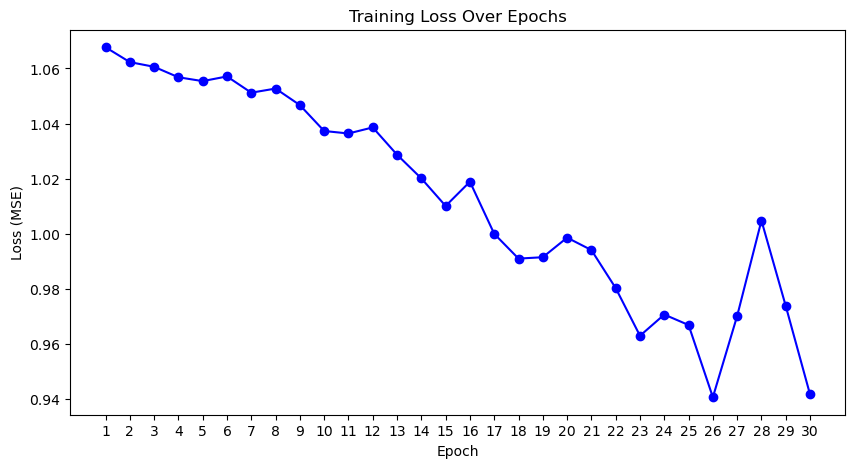

In [22]:
import matplotlib.pyplot as plt

# List of loss values from each epoch
loss_values = [
    1.0677, 1.0623, 1.0606, 1.0568, 1.0554, 1.0571, 1.0512, 1.0527, 1.0467, 1.0373,
    1.0364, 1.0386, 1.0287, 1.0201, 1.0101, 1.0189, 1.0000, 0.9910, 0.9915, 0.9986,
    0.9941, 0.9803, 0.9630, 0.9707, 0.9669, 0.9407, 0.9702, 1.0048, 0.9738, 0.9417
]

# Create epochs list
epochs = list(range(1, 31))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, marker='o',  color='b')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")

plt.xticks(epochs)
plt.show()


In [14]:
import torch
import pickle
import numpy as np

# Load model
with open("cnn_lstm_model.pkl", "rb") as f:
    model = pickle.load(f)

model.eval()

def predict_bvp(window):
    """
    window: numpy array shape (512,)
    """

    x = torch.tensor(window, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        pred = model(x).cpu().numpy().flatten()
    return pred


In [16]:
import numpy as np

# Load your real windows
X = np.load("X_windows.npy")   # shape (246, 512)

# Select one window
window = X[0]    # use first window
# OR window = X[10], X[99], any index 0–245

print("Window shape:", window.shape)


Window shape: (512,)


In [12]:
import torch
import torch.nn as nn
import pickle

# -----------------------------
# MODEL ARCHITECTURE (same as training)
# -----------------------------
class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=32, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# -----------------------------
# LOAD TRAINED MODEL WEIGHTS
# -----------------------------
model = CNNLSTM()
model.load_state_dict(torch.load("cnn_lstm_rppg.pth"))
model.eval()

# -----------------------------
# SAVE AS PICKLE (.pkl)
# -----------------------------
with open("cnn_lstm_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Saved model as cnn_lstm_model.pkl")


Saved model as cnn_lstm_model.pkl


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Load data
X = np.load("X_windows.npy")
Y = np.load("Y_bvp.npy")

X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)

# Dataset
class RPpgDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = RPpgDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# CNN1D Model
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv1d(16, 32, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(32, 1)
    def forward(self, x):
        x = self.cnn(x).squeeze(-1)
        return self.fc(x)

model = CNN1D()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training
for epoch in range(30):
    running_loss = 0.0
    for xb, yb in dataloader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    print(f"Epoch {epoch+1}/30, Loss: {running_loss/len(dataset):.4f}")

# Evaluation
model.eval()
preds = []
with torch.no_grad():
    for xb, yb in dataloader:
        out = model(xb)
        preds.append(out)
preds = torch.cat(preds, dim=0)
mse = nn.MSELoss()(preds, Y).item()
rmse = torch.sqrt(torch.tensor(mse)).item()
print(f"CNN1D → MSE: {mse:.4f}, RMSE: {rmse:.4f}")


Epoch 1/30, Loss: 1.0653
Epoch 2/30, Loss: 1.0626
Epoch 3/30, Loss: 1.0628
Epoch 4/30, Loss: 1.0602
Epoch 5/30, Loss: 1.0599
Epoch 6/30, Loss: 1.0618
Epoch 7/30, Loss: 1.0586
Epoch 8/30, Loss: 1.0581
Epoch 9/30, Loss: 1.0575
Epoch 10/30, Loss: 1.0614
Epoch 11/30, Loss: 1.0565
Epoch 12/30, Loss: 1.0562
Epoch 13/30, Loss: 1.0573
Epoch 14/30, Loss: 1.0580
Epoch 15/30, Loss: 1.0568
Epoch 16/30, Loss: 1.0537
Epoch 17/30, Loss: 1.0546
Epoch 18/30, Loss: 1.0541
Epoch 19/30, Loss: 1.0537
Epoch 20/30, Loss: 1.0548
Epoch 21/30, Loss: 1.0591
Epoch 22/30, Loss: 1.0589
Epoch 23/30, Loss: 1.0536
Epoch 24/30, Loss: 1.0521
Epoch 25/30, Loss: 1.0498
Epoch 26/30, Loss: 1.0542
Epoch 27/30, Loss: 1.0556
Epoch 28/30, Loss: 1.0510
Epoch 29/30, Loss: 1.0564
Epoch 30/30, Loss: 1.0462
CNN1D → MSE: 1.0615, RMSE: 1.0303


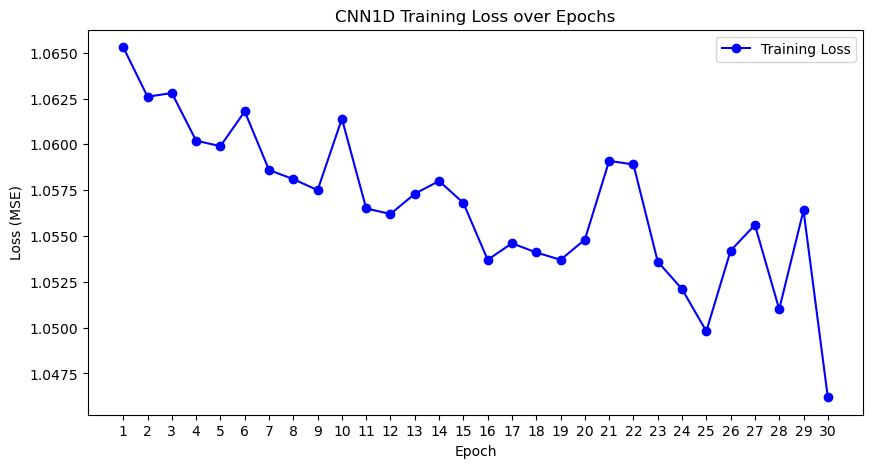

In [24]:
import matplotlib.pyplot as plt

# Loss values for each epoch
loss_values = [
    1.0653, 1.0626, 1.0628, 1.0602, 1.0599, 1.0618, 1.0586, 1.0581, 1.0575, 1.0614,
    1.0565, 1.0562, 1.0573, 1.0580, 1.0568, 1.0537, 1.0546, 1.0541, 1.0537, 1.0548,
    1.0591, 1.0589, 1.0536, 1.0521, 1.0498, 1.0542, 1.0556, 1.0510, 1.0564, 1.0462
]

# Epoch numbers
epochs = list(range(1, 31))

# Plot the graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='blue', label='Training Loss')
plt.title("CNN1D Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")

plt.xticks(epochs)
plt.legend()
plt.show()


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

X = np.load("X_windows.npy")
Y = np.load("Y_bvp.npy")

X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)

class RPpgDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = RPpgDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

class LSTMOnly(nn.Module):
    def __init__(self):
        super(LSTMOnly, self).__init__()
        self.lstm = nn.LSTM(1, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)
    def forward(self, x):
        x = x.permute(0,2,1)
        out,_ = self.lstm(x)
        out = out[:,-1,:]
        return self.fc(out)

model = LSTMOnly()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(30):
    running_loss = 0.0
    for xb, yb in dataloader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    print(f"Epoch {epoch+1}/30, Loss: {running_loss/len(dataset):.4f}")

model.eval()
preds = []
with torch.no_grad():
    for xb, yb in dataloader:
        preds.append(model(xb))
preds = torch.cat(preds, dim=0)
mse = nn.MSELoss()(preds, Y).item()
rmse = torch.sqrt(torch.tensor(mse)).item()
print(f"LSTMOnly → MSE: {mse:.4f}, RMSE: {rmse:.4f}")


Epoch 1/30, Loss: 1.0658
Epoch 2/30, Loss: 1.0638
Epoch 3/30, Loss: 1.0589
Epoch 4/30, Loss: 1.0590
Epoch 5/30, Loss: 1.0589
Epoch 6/30, Loss: 1.0564
Epoch 7/30, Loss: 1.0568
Epoch 8/30, Loss: 1.0566
Epoch 9/30, Loss: 1.0550
Epoch 10/30, Loss: 1.0541
Epoch 11/30, Loss: 1.0550
Epoch 12/30, Loss: 1.0531
Epoch 13/30, Loss: 1.0531
Epoch 14/30, Loss: 1.0533
Epoch 15/30, Loss: 1.0490
Epoch 16/30, Loss: 1.0469
Epoch 17/30, Loss: 1.0410
Epoch 18/30, Loss: 1.0343
Epoch 19/30, Loss: 1.0295
Epoch 20/30, Loss: 1.0244
Epoch 21/30, Loss: 1.0183
Epoch 22/30, Loss: 1.0075
Epoch 23/30, Loss: 1.0173
Epoch 24/30, Loss: 1.0005
Epoch 25/30, Loss: 0.9977
Epoch 26/30, Loss: 1.0052
Epoch 27/30, Loss: 0.9973
Epoch 28/30, Loss: 0.9871
Epoch 29/30, Loss: 0.9891
Epoch 30/30, Loss: 0.9776
LSTMOnly → MSE: 1.1645, RMSE: 1.0791


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

X = np.load("X_windows.npy")
Y = np.load("Y_bvp.npy")

X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)

class RPpgDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = RPpgDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

class GRUOnly(nn.Module):
    def __init__(self):
        super(GRUOnly, self).__init__()
        self.gru = nn.GRU(1, 64, batch_first=True)
        self.fc = nn.Linear(64,1)
    def forward(self,x):
        x = x.permute(0,2,1)
        out,_ = self.gru(x)
        out = out[:,-1,:]
        return self.fc(out)

model = GRUOnly()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(30):
    running_loss = 0.0
    for xb, yb in dataloader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    print(f"Epoch {epoch+1}/30, Loss: {running_loss/len(dataset):.4f}")

model.eval()
preds = []
with torch.no_grad():
    for xb, yb in dataloader:
        preds.append(model(xb))
preds = torch.cat(preds, dim=0)
mse = nn.MSELoss()(preds, Y).item()
rmse = torch.sqrt(torch.tensor(mse)).item()
print(f"GRUOnly → MSE: {mse:.4f}, RMSE: {rmse:.4f}")


Epoch 1/30, Loss: 1.0679
Epoch 2/30, Loss: 1.0625
Epoch 3/30, Loss: 1.0608
Epoch 4/30, Loss: 1.0623
Epoch 5/30, Loss: 1.0608
Epoch 6/30, Loss: 1.0586
Epoch 7/30, Loss: 1.0585
Epoch 8/30, Loss: 1.0574
Epoch 9/30, Loss: 1.0600
Epoch 10/30, Loss: 1.0570
Epoch 11/30, Loss: 1.0550
Epoch 12/30, Loss: 1.0541
Epoch 13/30, Loss: 1.0538
Epoch 14/30, Loss: 1.0550
Epoch 15/30, Loss: 1.0500
Epoch 16/30, Loss: 1.0516
Epoch 17/30, Loss: 1.0502
Epoch 18/30, Loss: 1.0498
Epoch 19/30, Loss: 1.0447
Epoch 20/30, Loss: 1.0479
Epoch 21/30, Loss: 1.0460
Epoch 22/30, Loss: 1.0459
Epoch 23/30, Loss: 1.0445
Epoch 24/30, Loss: 1.0396
Epoch 25/30, Loss: 1.0479
Epoch 26/30, Loss: 1.0341
Epoch 27/30, Loss: 1.0366
Epoch 28/30, Loss: 1.0336
Epoch 29/30, Loss: 1.0320
Epoch 30/30, Loss: 1.0267
GRUOnly → MSE: 1.1056, RMSE: 1.0515


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Load data
X = np.load("X_windows.npy")
Y = np.load("Y_bvp.npy")
X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)

# Dataset
class RPpgDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = RPpgDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# ResNet1D block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(identity)
        out += identity
        return self.relu(out)

# ResNet1D Model
class ResNet1D(nn.Module):
    def __init__(self):
        super(ResNet1D, self).__init__()
        self.layer1 = ResidualBlock(1, 16)
        self.layer2 = ResidualBlock(16, 32)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(32,1)
        
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool(x).squeeze(-1)
        return self.fc(x)

model = ResNet1D()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training
for epoch in range(30):
    running_loss = 0.0
    for xb, yb in dataloader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    print(f"Epoch {epoch+1}/30, Loss: {running_loss/len(dataset):.4f}")

# Evaluation
model.eval()
preds = []
with torch.no_grad():
    for xb, yb in dataloader:
        preds.append(model(xb))
preds = torch.cat(preds, dim=0)
mse = nn.MSELoss()(preds,Y).item()
rmse = torch.sqrt(torch.tensor(mse)).item()
print(f"ResNet1D → MSE: {mse:.4f}, RMSE: {rmse:.4f}")


Epoch 1/30, Loss: 1.0846
Epoch 2/30, Loss: 1.0609
Epoch 3/30, Loss: 1.0672
Epoch 4/30, Loss: 1.0556
Epoch 5/30, Loss: 1.0475
Epoch 6/30, Loss: 1.0514
Epoch 7/30, Loss: 1.0434
Epoch 8/30, Loss: 1.0566
Epoch 9/30, Loss: 1.0465
Epoch 10/30, Loss: 1.0670
Epoch 11/30, Loss: 1.0536
Epoch 12/30, Loss: 1.0462
Epoch 13/30, Loss: 1.0358
Epoch 14/30, Loss: 1.0469
Epoch 15/30, Loss: 1.0400
Epoch 16/30, Loss: 1.0301
Epoch 17/30, Loss: 1.0368
Epoch 18/30, Loss: 1.0449
Epoch 19/30, Loss: 1.0453
Epoch 20/30, Loss: 1.0372
Epoch 21/30, Loss: 1.0216
Epoch 22/30, Loss: 1.0313
Epoch 23/30, Loss: 1.0318
Epoch 24/30, Loss: 1.0284
Epoch 25/30, Loss: 1.0379
Epoch 26/30, Loss: 1.0468
Epoch 27/30, Loss: 1.0348
Epoch 28/30, Loss: 1.0361
Epoch 29/30, Loss: 1.0392
Epoch 30/30, Loss: 1.0256
ResNet1D → MSE: 1.0721, RMSE: 1.0354


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

# -----------------------------
# Load data
# -----------------------------
X = np.load("X_windows.npy")  # shape (246, 512)
Y = np.load("Y_bvp.npy")      # shape (246,)

X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (N, seq_len, 1)
Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)  # (N,1)

# -----------------------------
# Dataset
# -----------------------------
class RPpgDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = RPpgDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# -----------------------------
# Transformer Model
# -----------------------------
class TransformerRPPG(nn.Module):
    def __init__(self, seq_len=512, d_model=64, nhead=4, num_layers=2):
        super(TransformerRPPG, self).__init__()
        self.input_fc = nn.Linear(1, d_model)  # project 1D input to d_model
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)
    
    def forward(self, x):
        # x: (batch, seq_len, 1)
        x = self.input_fc(x)  # (batch, seq_len, d_model)
        x = self.transformer(x)  # (batch, seq_len, d_model)
        x = x[:, -1, :]  # take last timestep
        return self.fc_out(x)

model = TransformerRPPG()

# -----------------------------
# Loss & optimizer
# -----------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -----------------------------
# Training
# -----------------------------
num_epochs = 30
for epoch in range(num_epochs):
    running_loss = 0.0
    for xb, yb in dataloader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataset):.4f}")

# -----------------------------
# Evaluation
# -----------------------------
model.eval()
preds = []
with torch.no_grad():
    for xb, yb in dataloader:
        preds.append(model(xb))
preds = torch.cat(preds, dim=0)
mse = nn.MSELoss()(preds, Y).item()
rmse = torch.sqrt(torch.tensor(mse)).item()
print(f"Transformer → MSE: {mse:.4f}, RMSE: {rmse:.4f}")


Epoch 1/30, Loss: 2.3444
Epoch 2/30, Loss: 1.1470
Epoch 3/30, Loss: 1.0874
Epoch 4/30, Loss: 1.1143
Epoch 5/30, Loss: 1.0672
Epoch 6/30, Loss: 1.1129
Epoch 7/30, Loss: 1.0823
Epoch 8/30, Loss: 1.0841
Epoch 9/30, Loss: 1.1197
Epoch 10/30, Loss: 1.0747
Epoch 11/30, Loss: 1.0754
Epoch 12/30, Loss: 1.1124
Epoch 13/30, Loss: 1.0836
Epoch 14/30, Loss: 1.0551
Epoch 15/30, Loss: 1.0655
Epoch 16/30, Loss: 1.0526
Epoch 17/30, Loss: 1.0520
Epoch 18/30, Loss: 1.0726
Epoch 19/30, Loss: 1.0591
Epoch 20/30, Loss: 1.0795
Epoch 21/30, Loss: 1.0669
Epoch 22/30, Loss: 1.0732
Epoch 23/30, Loss: 1.0496
Epoch 24/30, Loss: 1.0288
Epoch 25/30, Loss: 1.0261
Epoch 26/30, Loss: 1.0473
Epoch 27/30, Loss: 1.0483
Epoch 28/30, Loss: 1.0402
Epoch 29/30, Loss: 1.0700
Epoch 30/30, Loss: 1.0530
Transformer → MSE: 1.0622, RMSE: 1.0306


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

# -----------------------------
# Load data
# -----------------------------
X = np.load("X_windows.npy")  # shape (246, 512)
Y = np.load("Y_bvp.npy")      # shape (246,)

X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (N,1,seq_len)
Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)  # (N,1)

# -----------------------------
# Dataset
# -----------------------------
class RPpgDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = RPpgDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# -----------------------------
# CNN-Transformer Model
# -----------------------------
class CNNTransformer(nn.Module):
    def __init__(self, seq_len=512, d_model=64, nhead=4, num_layers=2):
        super(CNNTransformer, self).__init__()
        # CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.input_fc = nn.Linear(32, d_model)  # project CNN features to d_model
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)
    
    def forward(self, x):
        # x: (batch, 1, seq_len)
        x = self.cnn(x)          # (batch, 32, seq_len)
        x = x.permute(0, 2, 1)   # (batch, seq_len, 32)
        x = self.input_fc(x)     # (batch, seq_len, d_model)
        x = self.transformer(x)  # (batch, seq_len, d_model)
        x = x[:, -1, :]          # take last timestep
        out = self.fc_out(x)
        return out

model = CNNTransformer()

# -----------------------------
# Loss & Optimizer
# -----------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -----------------------------
# Training Loop
# -----------------------------
num_epochs = 30
for epoch in range(num_epochs):
    running_loss = 0.0
    for xb, yb in dataloader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataset):.4f}")

# -----------------------------
# Evaluation
# -----------------------------
model.eval()
preds = []
with torch.no_grad():
    for xb, yb in dataloader:
        preds.append(model(xb))
preds = torch.cat(preds, dim=0)
mse = nn.MSELoss()(preds, Y).item()
rmse = torch.sqrt(torch.tensor(mse)).item()
print(f"CNN-Transformer → MSE: {mse:.4f}, RMSE: {rmse:.4f}")


Epoch 1/30, Loss: 2.0033
Epoch 2/30, Loss: 1.0866
Epoch 3/30, Loss: 1.0893
Epoch 4/30, Loss: 1.0883
Epoch 5/30, Loss: 1.0674
Epoch 6/30, Loss: 1.0919
Epoch 7/30, Loss: 1.0743
Epoch 8/30, Loss: 1.0671
Epoch 9/30, Loss: 1.0819
Epoch 10/30, Loss: 1.1054
Epoch 11/30, Loss: 1.0840
Epoch 12/30, Loss: 1.0708
Epoch 13/30, Loss: 1.0658
Epoch 14/30, Loss: 1.0847
Epoch 15/30, Loss: 1.0997
Epoch 16/30, Loss: 1.0405
Epoch 17/30, Loss: 1.0488
Epoch 18/30, Loss: 1.0522
Epoch 19/30, Loss: 1.0450
Epoch 20/30, Loss: 1.0514
Epoch 21/30, Loss: 1.0361
Epoch 22/30, Loss: 1.1002
Epoch 23/30, Loss: 1.0411
Epoch 24/30, Loss: 1.1034
Epoch 25/30, Loss: 1.0544
Epoch 26/30, Loss: 1.0846
Epoch 27/30, Loss: 1.0465
Epoch 28/30, Loss: 1.0546
Epoch 29/30, Loss: 1.0542
Epoch 30/30, Loss: 1.0214
CNN-Transformer → MSE: 1.0526, RMSE: 1.0260
